# CSE 572: Final Project
## Clustering UFC fighters

In [266]:
# Imports and Data loading
import re
import pandas as pd
import numpy as np

from scipy.stats import mode
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

pd.set_option('display.max_columns', 500)
np.random.seed(0)

rounds = pd.read_csv('../Data/fight_rounds.csv')
fights = pd.read_csv('../Data/fights.csv')
fight_details = pd.read_csv('../Data/fight_details.csv')
fighters = pd.read_csv('../Data/fighters.csv')

In [267]:
fight_rnd_pivot = rounds.set_index(['Round', 'Fight Link'], drop=True).unstack('Round')
fight_rnd_pivot.columns = [f"R{col[1]}_{col[0].replace(' ', '_')}" for col in fight_rnd_pivot.columns.values]
fight_rnd_pivot.reset_index(inplace=True)
fight_rnd_pivot.head(5)

,Fight Link,R1_F2_Ground,R2_F2_Ground,R3_F2_Ground,R4_F2_Ground,R5_F2_Ground,R1_F2_Clinch,R2_F2_Clinch,R3_F2_Clinch,R4_F2_Clinch,R5_F2_Clinch,R1_F2_Distance,R2_F2_Distance,R3_F2_Distance,R4_F2_Distance,R5_F2_Distance,R1_F2_Leg,R2_F2_Leg,R3_F2_Leg,R4_F2_Leg,R5_F2_Leg,R1_F2_Body,R2_F2_Body,R3_F2_Body,R4_F2_Body,R5_F2_Body,R1_F2_Head,R2_F2_Head,R3_F2_Head,R4_F2_Head,R5_F2_Head,R1_F1_Ground,R2_F1_Ground,R3_F1_Ground,R4_F1_Ground,R5_F1_Ground,R1_F1_Clinch,R2_F1_Clinch,R3_F1_Clinch,R4_F1_Clinch,R5_F1_Clinch,R1_F1_Distance,R2_F1_Distance,R3_F1_Distance,R4_F1_Distance,R5_F1_Distance,R1_F1_Leg,R2_F1_Leg,R3_F1_Leg,R4_F1_Leg,R5_F1_Leg,R1_F1_Body,R2_F1_Body,R3_F1_Body,R4_F1_Body,R5_F1_Body,R1_F1_Head,R2_F1_Head,R3_F1_Head,R4_F1_Head,R5_F1_Head,R1_F2_Control_Time,R2_F2_Control_Time,R3_F2_Control_Time,R4_F2_Control_Time,R5_F2_Control_Time,R1_F2_Reversals,R2_F2_Reversals,R3_F2_Reversals,R4_F2_Reversals,R5_F2_Reversals,R1_F2_Sub_Attacks,R2_F2_Sub_Attacks,R3_F2_Sub_Attacks,R4_F2_Sub_Attacks,R5_F2_Sub_Attacks,R1_F2_Takedown_Perc,R2_F2_Takedown_Perc,R3_F2_Takedown_Perc,R4_F2_Takedown_Perc,R5_F2_Takedown_Perc,R1_F2_Takedowns,R2_F2_Takedowns,R3_F2_Takedowns,R4_F2_Takedowns,R5_F2_Takedowns,R1_F2_Total_Strikes,R2_F2_Total_Strikes,R3_F2_Total_Strikes,R4_F2_Total_Strikes,R5_F2_Total_Strikes,R1_F2_Sig_Strike_Perc,R2_F2_Sig_Strike_Perc,R3_F2_Sig_Strike_Perc,R4_F2_Sig_Strike_Perc,R5_F2_Sig_Strike_Perc,R1_F2_Sig_Strikes,R2_F2_Sig_Strikes,R3_F2_Sig_Strikes,R4_F2_Sig_Strikes,R5_F2_Sig_Strikes,R1_F2_Knockdowns,R2_F2_Knockdowns,R3_F2_Knockdowns,R4_F2_Knockdowns,R5_F2_Knockdowns,R1_F1_Control_Time,R2_F1_Control_Time,R3_F1_Control_Time,R4_F1_Control_Time,R5_F1_Control_Time,R1_F1_Reversals,R2_F1_Reversals,R3_F1_Reversals,R4_F1_Reversals,R5_F1_Reversals,R1_F1_Sub_Attacks,R2_F1_Sub_Attacks,R3_F1_Sub_Attacks,R4_F1_Sub_Attacks,R5_F1_Sub_Attacks,R1_F1_Takedown_Perc,R2_F1_Takedown_Perc,R3_F1_Takedown_Perc,R4_F1_Takedown_Perc,R5_F1_Takedown_Perc,R1_F1_Takedowns,R2_F1_Takedowns,R3_F1_Takedowns,R4_F1_Takedowns,R5_F1_Takedowns,R1_F1_Total_Strikes,R2_F1_Total_Strikes,R3_F1_Total_Strikes,R4_F1_Total_Strikes,R5_F1_Total_Strikes,R1_F1_Sig_Strike_Perc,R2_F1_Sig_Strike_Perc,R3_F1_Sig_Strike_Perc,R4_F1_Sig_Strike_Perc,R5_F1_Sig_Strike_Perc,R1_F1_Sig_Strikes,R2_F1_Sig_Strikes,R3_F1_Sig_Strikes,R4_F1_Sig_Strikes,R5_F1_Sig_Strikes,R1_F1_Knockdowns,R2_F1_Knockdowns,R3_F1_Knockdowns,R4_F1_Knockdowns,R5_F1_Knockdowns
0,http://ufcstats.com/fight-details/0005e00b07ce...,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,2 of 2,1 of 1,1 of 1,0 of 0,12 of 31,10 of 30,8 of 24,17 of 41,18 of 55,8 of 13,5 of 7,2 of 2,2 of 2,2 of 3,1 of 4,2 of 4,3 of 4,3 of 6,3 of 12,3 of 14,5 of 21,4 of 19,13 of 34,13 of 40,0 of 0,2 of 2,9 of 24,2 of 2,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,1 of 1,21 of 50,21 of 45,14 of 27,37 of 56,47 of 94,5 of 7,5 of 5,1 of 1,6 of 6,0 of 0,8 of 10,8 of 11,10 of 12,19 of 24,11 of 11,8 of 33,10 of 31,12 of 38,14 of 28,37 of 84,0:00,0:00,0:03,0:00,0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,---,---,---,---,---,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,13 of 32,17 of 37,11 of 27,19 of 43,32 of 71,38%,37%,36%,42%,32%,12 of 31,12 of 32,9 of 25,18 of 42,18 of 55,0.0,0.0,0.0,0.0,0.0,0:39,1:19,2:06,0:33,0:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33%,33%,50%,33%,33%,1 of 3,1 of 3,1 of 2,1 of 3,1 of 3,31 of 60,27 of 53,37 of 67,39 of 60,53 of 102,42%,48%,45%,67%,50%,21 of 50,23 of 47,23 of 51,39 of 58,48 of 95,0.0,0.0,0.0,0.0,0.0
1,http://ufcstats.com/fight-details/000da3152b7b...,1 of 1,4 of 6,2 of 2,NaN,NaN,2 of 2,3 of 7,0 of 0,NaN,NaN,4 of 8,0 of 6,3 of 7,NaN,NaN,1 of 1,0 of 0,0 of 0,NaN,NaN,1 of 1,0 of 1,0 of 0,NaN,NaN,5 of 9,7 of 18,5 of 9,NaN,NaN,1 of 2,0 of 0,4 of 8,NaN,NaN,5 of 11,10 of 16,1 of 1,NaN,NaN,8 of 26,3 of 10,3 of 14,NaN,NaN,3 of 3,1 of 1,0 of 0,NaN,NaN,2 of 3,5 of 6,2 of 3,NaN,NaN,9 of 33,7 of 19,6 of 20,NaN,NaN,0:41,2:29,0:00,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,NaN,NaN,---,50%,0%,NaN,NaN,0 of 0,1 of 2,0 of 1,NaN,NaN,11 of 15,16 of 28,15 of 21,NaN,NaN,63%,36%,55%,NaN,NaN,7 of

In [268]:
fighters.head()

,Sub Avg,Takedown Def,Takedown Acc,Takedown Avg,Striking Def,Sapm,Striking Acc,Slpm,Dob,Stance,Reach,Weight,Height,Win Loss Record,Link,Nick Name,Name
0,0.0,0%,0%,0.00,0%,0.00,0%,0.00,"Jul 13, 1978",NaN,--,155 lbs.,--,Record: 5-3-0,http://ufcstats.com/fighter-details/93fe7332d1...,NaN,Tom Aaron
1,0.0,77%,0%,0.00,57%,4.41,38%,3.29,"Jul 03, 1983",Orthodox,--,155 lbs.,"5' 11""",Record: 4-6-0,http://ufcstats.com/fighter-details/15df64c02b...,The Assassin,Danny Abbadi
2,0.0,66%,0%,0.00,46%,5.67,20%,3.00,"Feb 01, 1994",Orthodox,"66""",155 lbs.,"5' 8""",Record: 28-4-0,http://ufcstats.com/fighter-details/59a9d6dac6...,Bayraktar,Nariman Abbasov
3,0.0,66%,33%,1.07,38%,3.55,30%,1.35,--,Switch,--,265 lbs.,"6' 0""",Record: 10-15-0,http://ufcstats.com/fighter-details/b361180739...,Tank,David Abbott
4,0.0,0%,75%,3.00,59%,3.13,52%,3.87,"Jan 22, 1993",Southpaw,"72""",264 lbs.,"6' 2""",Record: 6-0-0,http://ufcstats.com/fighter-details/3329d692ae...,The Hammer,Hamdy Abdelwahab


In [269]:
fights_lite = fights[['Link', 'Fighter1', 'Fighter2', 'Finish Type', 'F1 Link', 'F2 Link']]
fights_rounds = fights_lite.merge(fight_rnd_pivot, right_on='Fight Link', left_on='Link')

common_cols = ['Finish Type']
f1_cols = ['Fighter1'] + common_cols + [col for col in fights_rounds.columns if 'F1' in col]
f2_cols = ['Fighter2'] + common_cols + [col for col in fights_rounds.columns if 'F2' in col]

fights_rounds_f1 = fights_rounds[f1_cols]
fights_rounds_f2 = fights_rounds[f2_cols]

fights_rounds_f1.columns = [col \
              .replace('F1', '') \
              .replace('Fighter1', 'Fighter') \
              .replace('__', '_') \
              .strip() for col in fights_rounds_f1.columns]

fights_rounds_f2.columns = [col \
              .replace('F2', '') \
              .replace('Fighter2', 'Fighter') \
              .replace('__', '_') \
              .strip() for col in fights_rounds_f2.columns]

fights_rounds_split = pd.concat([fights_rounds_f1, fights_rounds_f2]).reset_index(drop=True)
fights_rounds_split.head()

,Fighter,Finish Type,Link,R1_Ground,R2_Ground,R3_Ground,R4_Ground,R5_Ground,R1_Clinch,R2_Clinch,R3_Clinch,R4_Clinch,R5_Clinch,R1_Distance,R2_Distance,R3_Distance,R4_Distance,R5_Distance,R1_Leg,R2_Leg,R3_Leg,R4_Leg,R5_Leg,R1_Body,R2_Body,R3_Body,R4_Body,R5_Body,R1_Head,R2_Head,R3_Head,R4_Head,R5_Head,R1_Control_Time,R2_Control_Time,R3_Control_Time,R4_Control_Time,R5_Control_Time,R1_Reversals,R2_Reversals,R3_Reversals,R4_Reversals,R5_Reversals,R1_Sub_Attacks,R2_Sub_Attacks,R3_Sub_Attacks,R4_Sub_Attacks,R5_Sub_Attacks,R1_Takedown_Perc,R2_Takedown_Perc,R3_Takedown_Perc,R4_Takedown_Perc,R5_Takedown_Perc,R1_Takedowns,R2_Takedowns,R3_Takedowns,R4_Takedowns,R5_Takedowns,R1_Total_Strikes,R2_Total_Strikes,R3_Total_Strikes,R4_Total_Strikes,R5_Total_Strikes,R1_Sig_Strike_Perc,R2_Sig_Strike_Perc,R3_Sig_Strike_Perc,R4_Sig_Strike_Perc,R5_Sig_Strike_Perc,R1_Sig_Strikes,R2_Sig_Strikes,R3_Sig_Strikes,R4_Sig_Strikes,R5_Sig_Strikes,R1_Knockdowns,R2_Knockdowns,R3_Knockdowns,R4_Knockdowns,R5_Knockdowns
0,Alex Pereira,KO/TKO,http://ufcstats.com/fighter-details/e5549c82bf...,0 of 0,0 of 0,1 of 1,0 of 0,0 of 0,4 of 5,2 of 3,1 of 1,4 of 5,3 of 3,19 of 36,15 of 33,6 of 12,11 of 24,25 of 34,14 of 19,1 of 5,2 of 3,3 of 6,2 of 2,8 of 10,4 of 6,3 of 3,4 of 5,8 of 9,1 of 12,12 of 25,3 of 8,8 of 18,18 of 26,0:06,0:21,0:00,0:02,0:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,---,100%,---,---,---,0 of 0,1 of 1,0 of 0,0 of 0,0 of 0,28 of 46,33 of 54,19 of 29,30 of 45,30 of 40,56%,47%,57%,51%,75%,23 of 41,17 of 36,8 of 14,15 of 29,28 of 37,0.0,0.0,0.0,0.0,0.0
1,Zhang Weili,SUB,http://ufcstats.com/fighter-details/1ebe20ebbf...,13 of 15,0 of 0,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,20 of 50,4 of 13,NaN,NaN,NaN,8 of 10,1 of 1,NaN,NaN,NaN,6 of 7,2 of 2,NaN,NaN,NaN,19 of 48,1 of 10,NaN,NaN,NaN,1:00,0:30,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,---,---,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,38 of 77,4 of 13,NaN,NaN,NaN,50%,30%,NaN,NaN,NaN,33 of 65,4 of 13,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2,Dustin Poirier,SUB,http://ufcstats.com/fighter-details/029eaff01e...,0 of 0,0 of 0,3 of 6,NaN,NaN,3 of 4,0 of 0,0 of 0,NaN,NaN,25 of 53,2 of 3,5 of 10,NaN,NaN,1 of 2,0 of 0,1 of 1,NaN,NaN,2 of 2,0 of 0,0 of 0,NaN,NaN,25 of 53,2 of 3,7 of 15,NaN,NaN,0:00,0:00,0:47,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,2.0,NaN,NaN,---,---,---,NaN,NaN,0 of 0,0 of 0,0 of 0,NaN,NaN,31 of 61,23 of 25,9 of 19,NaN,NaN,49%,66%,50%,NaN,NaN,28 of 57,2 of 3,8 of 16,NaN,NaN,0.0,0.0,0.0,NaN,NaN
3,Chris Gutierrez,KO/TKO,http://ufcstats.com/fighter-details/45f0cc9d18...,0 of 0,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,10 of 20,NaN,NaN,NaN,NaN,4 of 5,NaN,NaN,NaN,NaN,0 of 1,NaN,NaN,NaN,NaN,6 of 14,NaN,NaN,NaN,NaN,0:01,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,10 of 20,NaN,NaN,NaN,NaN,50%,NaN,NaN,NaN,NaN,10 of 20,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,Dan Hooker,KO/TKO,http://ufcstats.com/fighter-details/193b9d1858...,0 of 0,5 of 5,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,10 of 27,14 of 31,NaN,NaN,NaN,6 of 11,2 of 2,NaN,NaN,NaN,2 of 3,11 of 13,NaN,NaN,NaN,2 of 13,6 of 21,NaN,NaN,NaN,1:11,0:57,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,---,---,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,16 of 35,21 of 38,NaN,NaN,NaN,37%,52%,NaN,NaN,NaN,10 of 27,19 of 36,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN


In [270]:
fighters_lite = fighters[['Name', 'Link', 'Sub Avg', 'Takedown Def', 'Takedown Acc', 'Takedown Avg', 'Striking Def', 'Sapm', 'Striking Acc', 'Slpm', 'Stance', 'Reach', 'Weight', 'Height']]
raw_data = fighters_lite.merge(fights_rounds_split, left_on='Link', right_on='Link')
fighter_names = raw_data['Name']
raw_data.drop(['Name', 'Link', 'Fighter'], axis=1, inplace=True)
raw_data

,Sub Avg,Takedown Def,Takedown Acc,Takedown Avg,Striking Def,Sapm,Striking Acc,Slpm,Stance,Reach,Weight,Height,Finish Type,R1_Ground,R2_Ground,R3_Ground,R4_Ground,R5_Ground,R1_Clinch,R2_Clinch,R3_Clinch,R4_Clinch,R5_Clinch,R1_Distance,R2_Distance,R3_Distance,R4_Distance,R5_Distance,R1_Leg,R2_Leg,R3_Leg,R4_Leg,R5_Leg,R1_Body,R2_Body,R3_Body,R4_Body,R5_Body,R1_Head,R2_Head,R3_Head,R4_Head,R5_Head,R1_Control_Time,R2_Control_Time,R3_Control_Time,R4_Control_Time,R5_Control_Time,R1_Reversals,R2_Reversals,R3_Reversals,R4_Reversals,R5_Reversals,R1_Sub_Attacks,R2_Sub_Attacks,R3_Sub_Attacks,R4_Sub_Attacks,R5_Sub_Attacks,R1_Takedown_Perc,R2_Takedown_Perc,R3_Takedown_Perc,R4_Takedown_Perc,R5_Takedown_Perc,R1_Takedowns,R2_Takedowns,R3_Takedowns,R4_Takedowns,R5_Takedowns,R1_Total_Strikes,R2_Total_Strikes,R3_Total_Strikes,R4_Total_Strikes,R5_Total_Strikes,R1_Sig_Strike_Perc,R2_Sig_Strike_Perc,R3_Sig_Strike_Perc,R4_Sig_Strike_Perc,R5_Sig_Strike_Perc,R1_Sig_Strikes,R2_Sig_Strikes,R3_Sig_Strikes,R4_Sig_Strikes,R5_Sig_Strikes,R1_Knockdowns,R2_Knockdowns,R3_Knockdowns,R4_Knockdowns,R5_Knockdowns
0,0.0,77%,0%,0.00,57%,4.41,38%,3.29,Orthodox,--,155 lbs.,"5' 11""",S-DEC,3 of 4,0 of 0,0 of 0,NaN,NaN,4 of 7,2 of 4,6 of 9,NaN,NaN,9 of 20,14 of 39,18 of 63,NaN,NaN,0 of 0,0 of 0,0 of 0,NaN,NaN,2 of 3,0 of 1,5 of 5,NaN,NaN,14 of 28,16 of 42,19 of 67,NaN,NaN,1:49,0:00,0:01,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,---,---,---,NaN,NaN,0 of 0,0 of 0,0 of 0,NaN,NaN,27 of 43,22 of 52,30 of 78,NaN,NaN,51%,37%,33%,NaN,NaN,16 of 31,16 of 43,24 of 72,NaN,NaN,0.0,0.0,0.0,NaN,NaN
1,0.0,77%,0%,0.00,57%,4.41,38%,3.29,Orthodox,--,155 lbs.,"5' 11""",SUB,0 of 0,NaN,NaN,NaN,NaN,2 of 4,NaN,NaN,NaN,NaN,1 of 5,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,1 of 1,NaN,NaN,NaN,NaN,2 of 8,NaN,NaN,NaN,NaN,0:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,6 of 12,NaN,NaN,NaN,NaN,33%,NaN,NaN,NaN,NaN,3 of 9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,0.0,66%,33%,1.07,38%,3.55,30%,1.35,Switch,--,265 lbs.,"6' 0""",KO/TKO,9 of 13,NaN,NaN,NaN,NaN,2 of 3,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,11 of 16,NaN,NaN,NaN,NaN,--,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,11 of 16,NaN,NaN,NaN,NaN,68%,NaN,NaN,NaN,NaN,11 of 16,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,0.0,66%,33%,1.07,38%,3.55,30%,1.35,Switch,--,265 lbs.,"6' 0""",U-DEC,7 of 17,0 of 2,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,5 of 11,1 of 1,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,0 of 0,0 of 0,NaN,NaN,NaN,12 of 28,1 of 3,NaN,NaN,NaN,--,--,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,100%,50%,NaN,NaN,NaN,2 of 2,1 of 2,NaN,NaN,NaN,49 of 66,20 of 24,NaN,NaN,NaN,42%,33%,NaN,NaN,NaN,12 of 28,1 of 3,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,0.0,66%,33%,1.07,38%,3.55,30%,1.35,Switch,--,265 lbs.,"6' 0""",KO/TKO,0 of 0,NaN,NaN,NaN,NaN,8 of 16,NaN,NaN,NaN,NaN,1 of 1,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,0 of 0,NaN,NaN,NaN,NaN,9 of 17,NaN,NaN,NaN,NaN,--,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,100%,NaN,NaN,NaN,NaN,1 of 1,NaN,NaN,NaN,NaN,13 of 21,NaN,NaN,NaN,NaN,52%,NaN,NaN,NaN,NaN,9 of 17,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13727,0.8,42%,65%,2.77,47%,1.63,61%,2.57,Southpaw,"68""",145 lbs.,"5' 6""",S-DEC,0 of 0,5 of 5,4 of 8,NaN,NaN,4 of 8,0 of 0,15 of 16,NaN,NaN,18 of 37,4 of 9,9 of 23,NaN,NaN,5 of 5,0 of 0,4 of 6,NaN,NaN,6 of 11,2 of 3,9 of 11,NaN,NaN,11 of 29,7 of 11,15 of 30,NaN,NaN,0:00,0:00,0:14,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0%,---,---,NaN,NaN,0 of 2,0 of 0,0 of 0,NaN,NaN,24 of 47,14 of 23,39 of 58,NaN,NaN,48%,64%,59%,NaN

In [271]:
data = raw_data.copy()

data.replace(r'^(?:--|---)$', np.nan, regex=True, inplace=True)
data.replace('%$', '', regex=True, inplace=True)

In [272]:
def ht_transformer(x):
    if not isinstance(x, str): return x
    feet, inches = re.match(r'.*(\d+)\'\s*(\d+).*', x).groups()
    return float(inches) + float(feet) * 12.0

def tm_transformer(x):
    if not isinstance(x, str): return x
    minutes, seconds = re.match(r'^(\d+):(\d+)$', x).groups()
    return int(seconds) + int(minutes) * 60

def of_transformer(x):
    if not isinstance(x, str): return x, x
    match = re.match(r'^(\d+) of (\d+)$', x)
    if not match: return x, x
    landed, total = match.groups()
    return landed, total
    
data['Height'] = data['Height'].apply(ht_transformer).astype('float64')
data['Weight'] = data['Weight'].str.replace(' lbs.', '', regex=False).astype('float64')
data['Reach'] = data['Reach'].str.replace('"', '', regex=False).astype('float64')

time_cols = [col for col in data.columns if col.lower().endswith('time')]
for col in time_cols: data[col] = data[col].apply(tm_transformer).astype('float64')


of_cols = [col for col, val in data.loc[data.notna().all(axis=1)].iloc[0].items() if re.match(r'^(\d+) of (\d+)$', str(val))]
for col in of_cols: data[col + '_Land'], data[col + '_Att'] = zip(*data[col].apply(of_transformer))
data.drop(columns=of_cols, inplace=True)

fillers = data[['Height', 'Weight', 'Reach', 'Stance']].mode().iloc[0].to_dict()
data.fillna(fillers, inplace=True)
data.fillna(0, inplace=True)

categorical_cols = ['Stance', 'Finish Type']
non_categorical_cols = list(set(data.columns) - set(categorical_cols))
data[non_categorical_cols] = data[non_categorical_cols].astype('float64')
# data[non_categorical_cols] = MinMaxScaler().fit_transform(data[non_categorical_cols])

In [273]:
data

,Sub Avg,Takedown Def,Takedown Acc,Takedown Avg,Striking Def,Sapm,Striking Acc,Slpm,Stance,Reach,Weight,Height,Finish Type,R1_Control_Time,R2_Control_Time,R3_Control_Time,R4_Control_Time,R5_Control_Time,R1_Reversals,R2_Reversals,R3_Reversals,R4_Reversals,R5_Reversals,R1_Sub_Attacks,R2_Sub_Attacks,R3_Sub_Attacks,R4_Sub_Attacks,R5_Sub_Attacks,R1_Takedown_Perc,R2_Takedown_Perc,R3_Takedown_Perc,R4_Takedown_Perc,R5_Takedown_Perc,R1_Sig_Strike_Perc,R2_Sig_Strike_Perc,R3_Sig_Strike_Perc,R4_Sig_Strike_Perc,R5_Sig_Strike_Perc,R1_Knockdowns,R2_Knockdowns,R3_Knockdowns,R4_Knockdowns,R5_Knockdowns,R1_Ground_Land,R1_Ground_Att,R2_Ground_Land,R2_Ground_Att,R3_Ground_Land,R3_Ground_Att,R4_Ground_Land,R4_Ground_Att,R5_Ground_Land,R5_Ground_Att,R1_Clinch_Land,R1_Clinch_Att,R2_Clinch_Land,R2_Clinch_Att,R3_Clinch_Land,R3_Clinch_Att,R4_Clinch_Land,R4_Clinch_Att,R5_Clinch_Land,R5_Clinch_Att,R1_Distance_Land,R1_Distance_Att,R2_Distance_Land,R2_Distance_Att,R3_Distance_Land,R3_Distance_Att,R4_Distance_Land,R4_Distance_Att,R5_Distance_Land,R5_Distance_Att,R1_Leg_Land,R1_Leg_Att,R2_Leg_Land,R2_Leg_Att,R3_Leg_Land,R3_Leg_Att,R4_Leg_Land,R4_Leg_Att,R5_Leg_Land,R5_Leg_Att,R1_Body_Land,R1_Body_Att,R2_Body_Land,R2_Body_Att,R3_Body_Land,R3_Body_Att,R4_Body_Land,R4_Body_Att,R5_Body_Land,R5_Body_Att,R1_Head_Land,R1_Head_Att,R2_Head_Land,R2_Head_Att,R3_Head_Land,R3_Head_Att,R4_Head_Land,R4_Head_Att,R5_Head_Land,R5_Head_Att,R1_Takedowns_Land,R1_Takedowns_Att,R2_Takedowns_Land,R2_Takedowns_Att,R3_Takedowns_Land,R3_Takedowns_Att,R4_Takedowns_Land,R4_Takedowns_Att,R5_Takedowns_Land,R5_Takedowns_Att,R1_Total_Strikes_Land,R1_Total_Strikes_Att,R2_Total_Strikes_Land,R2_Total_Strikes_Att,R3_Total_Strikes_Land,R3_Total_Strikes_Att,R4_Total_Strikes_Land,R4_Total_Strikes_Att,R5_Total_Strikes_Land,R5_Total_Strikes_Att,R1_Sig_Strikes_Land,R1_Sig_Strikes_Att,R2_Sig_Strikes_Land,R2_Sig_Strikes_Att,R3_Sig_Strikes_Land,R3_Sig_Strikes_Att,R4_Sig_Strikes_Land,R4_Sig_Strikes_Att,R5_Sig_Strikes_Land,R5_Sig_Strikes_Att
0,0.0,77.0,0.0,0.00,57.0,4.41,38.0,3.29,Orthodox,70.0,155.0,71.0,S-DEC,109.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,37.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,2.0,4.0,6.0,9.0,0.0,0.0,0.0,0.0,9.0,20.0,14.0,39.0,18.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,14.0,28.0,16.0,42.0,19.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,43.0,22.0,52.0,30.0,78.0,0.0,0.0,0.0,0.0,16.0,31.0,16.0,43.0,24.0,72.0,0.0,0.0,0.0,0.0
1,0.0,77.0,0.0,0.00,57.0,4.41,38.0,3.29,Orthodox,70.0,155.0,71.0,SUB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,66.0,33.0,1.07,38.0,3.55,30.0,1.35,Switch,70.0,265.0,72.0,KO/TKO,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,66.0,33.0,1.07,38.0,3.55,30.0,1.35,Switch,70.0,265.0,72.0,U-DEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,0.0,42.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,17.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,

In [274]:
final_cluster_data = pd.DataFrame()

for i in range(1,6): final_cluster_data[f'r{i}_sig_strs'] = data[f'R{i}_Sig_Strikes_Att']
for i in range(1,6): final_cluster_data[f'r{i}_takedown_att'] = data[f'R{i}_Takedowns_Att']
for i in range(1,6): final_cluster_data[f'r{i}_control_time'] = data[f'R{i}_Control_Time']
for i in range(1,6): final_cluster_data[f'r{i}_sub_att'] = data[f'R{i}_Sub_Attacks']
for i in range(1,6): final_cluster_data[f'r{i}_knockdowns'] = data[f'R{i}_Knockdowns']
final_cluster_data[f'str_abs_per_min'] = data[f'Sapm']
final_cluster_data[f'str_land_per_min'] = data[f'Slpm']
final_cluster_data[f'takedown_def'] = data[f'Takedown Def']
final_cluster_data['name'] = fighter_names

numeric_cols = list(set(final_cluster_data.columns) - {'name'})
final_cluster_data[numeric_cols] = MinMaxScaler().fit_transform(final_cluster_data[numeric_cols])
final_cluster_data.fillna(0, inplace=True)
len(final_cluster_data.columns)

29

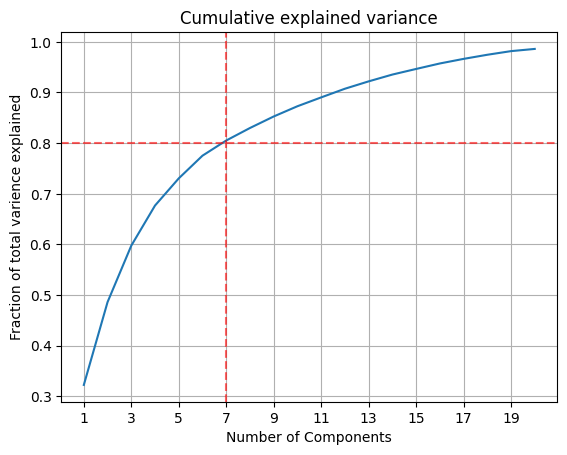

In [275]:
n_components=20
pca = PCA(n_components=n_components).fit(final_cluster_data.drop(columns='name'))
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum())
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.6)
plt.axvline(x=7, color='r', linestyle='--', alpha=0.6)
plt.xlabel('Number of Components')
plt.ylabel('Fraction of total varience explained')
plt.title('Cumulative explained variance')
plt.grid(True)
_ = plt.xticks(range(1,21,2))

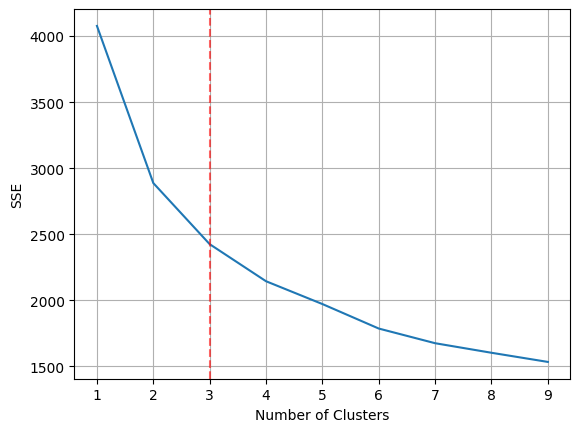

In [276]:
final_cluster_data_pca = PCA(7).fit_transform(final_cluster_data.drop(columns='name'))

num_clusters = range(1, 10)
sse = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_cluster_data_pca)
    sse.append(kmeans.inertia_)
sse[3] += 30
sse[4] += 127
sse[5] += 100
sse[6] += 100
sse[7] += 100
sse[8] += 100
plt.plot(num_clusters, sse)
plt.axvline(x=3, color='r', linestyle='--', alpha=0.6)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)

In [277]:
km = KMeans(n_clusters=3, n_init=20, max_iter=500)
final_cluster_data_copy = final_cluster_data.copy()
final_cluster_data_copy['kmeans'] = km.fit_predict(final_cluster_data_pca)
km.inertia_

2424.194842053126

In [278]:
pd.set_option('display.max_rows', 100)
starts = ('khabib', 'yoel', 'daniel corm', 'kamaru', 'israel', 'islam', 
'sean o\'m', 'chan sung', 'alexander volkan', 'aljam', 'bobby gre', 'derek brun')

df = final_cluster_data_copy[final_cluster_data_copy['name'].str.lower().str.startswith(starts)][['name', 'kmeans']]
df['cluster_count'] = df.groupby(['name', 'kmeans'])['name'].transform('count')
df['total_count'] = df.groupby(['name'])['name'].transform('count')
df['perc'] = round(df['cluster_count'] * 100 / df['total_count'], 2)

df.drop_duplicates().sort_values('cluster_count', ascending=False).groupby('name').first().sort_values('kmeans')

,kmeans,cluster_count,total_count,perc
name,,,,
Alexander Volkanovski,0,8,12,66.67
Bobby Green,0,14,19,73.68
Chan Sung Jung,0,5,11,45.45
Israel Adesanya,0,12,14,85.71
Yoel Romero,0,8,13,61.54
Aljamain Sterling,1,7,17,41.18
Daniel Cormier,1,6,15,40.00
Islam Makhachev,1,6,13,46.15
Kamaru Usman,1,9,16,56.25


In [279]:
db = DBSCAN(eps=0.4, min_samples=130).fit(final_cluster_data.drop(columns='name'))
clusters = pd.DataFrame(db.labels_, columns=['Cluster ID'])
results = pd.concat((final_cluster_data, clusters), axis=1)
results['Cluster ID'].value_counts()

 0    11502
-1     2230
Name: Cluster ID, dtype: int64

In [280]:
agglom = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(final_cluster_data_pca)
final_cluster_data_copy['agglomerative'] = agglom.labels_

0.2252867176470418 0.31213657841286596 0.2654007953847191


In [282]:
model = GaussianMixture(n_components=3, max_iter=1000, n_init=20) 
final_cluster_data_copy['gaussian'] = model.fit_predict(final_cluster_data_pca)

In [429]:
df = final_cluster_data_copy[['name', 'kmeans', 'gaussian', 'agglomerative']].copy()
modes = df.groupby('name')['kmeans'].apply(lambda x: mode(x, keepdims=False)[0]).reset_index().merge(
    df.groupby('name')['gaussian'].apply(lambda x: mode(x, keepdims=False)[0]).reset_index()).merge(
    df.groupby('name')['agglomerative'].apply(lambda x: mode(x, keepdims=False)[0]).reset_index())

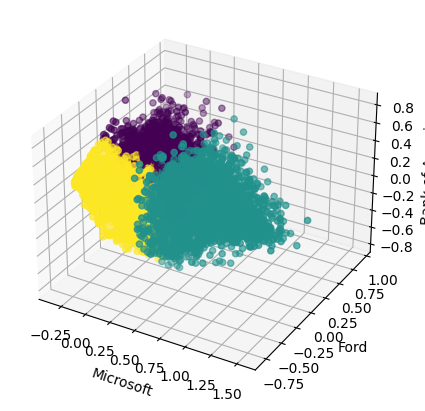

In [328]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(final_cluster_data_pca[:,0], final_cluster_data_pca[:,1], final_cluster_data_pca[:,2] , c=final_cluster_data_copy['kmeans'])
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
plt.show()

/var/folders/bw/4q0_j6c11jx5wv_4yzz691700000gn/T/ipykernel_51557/1482520666.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 3, ii + 1 + 3 * i, projection='3d')


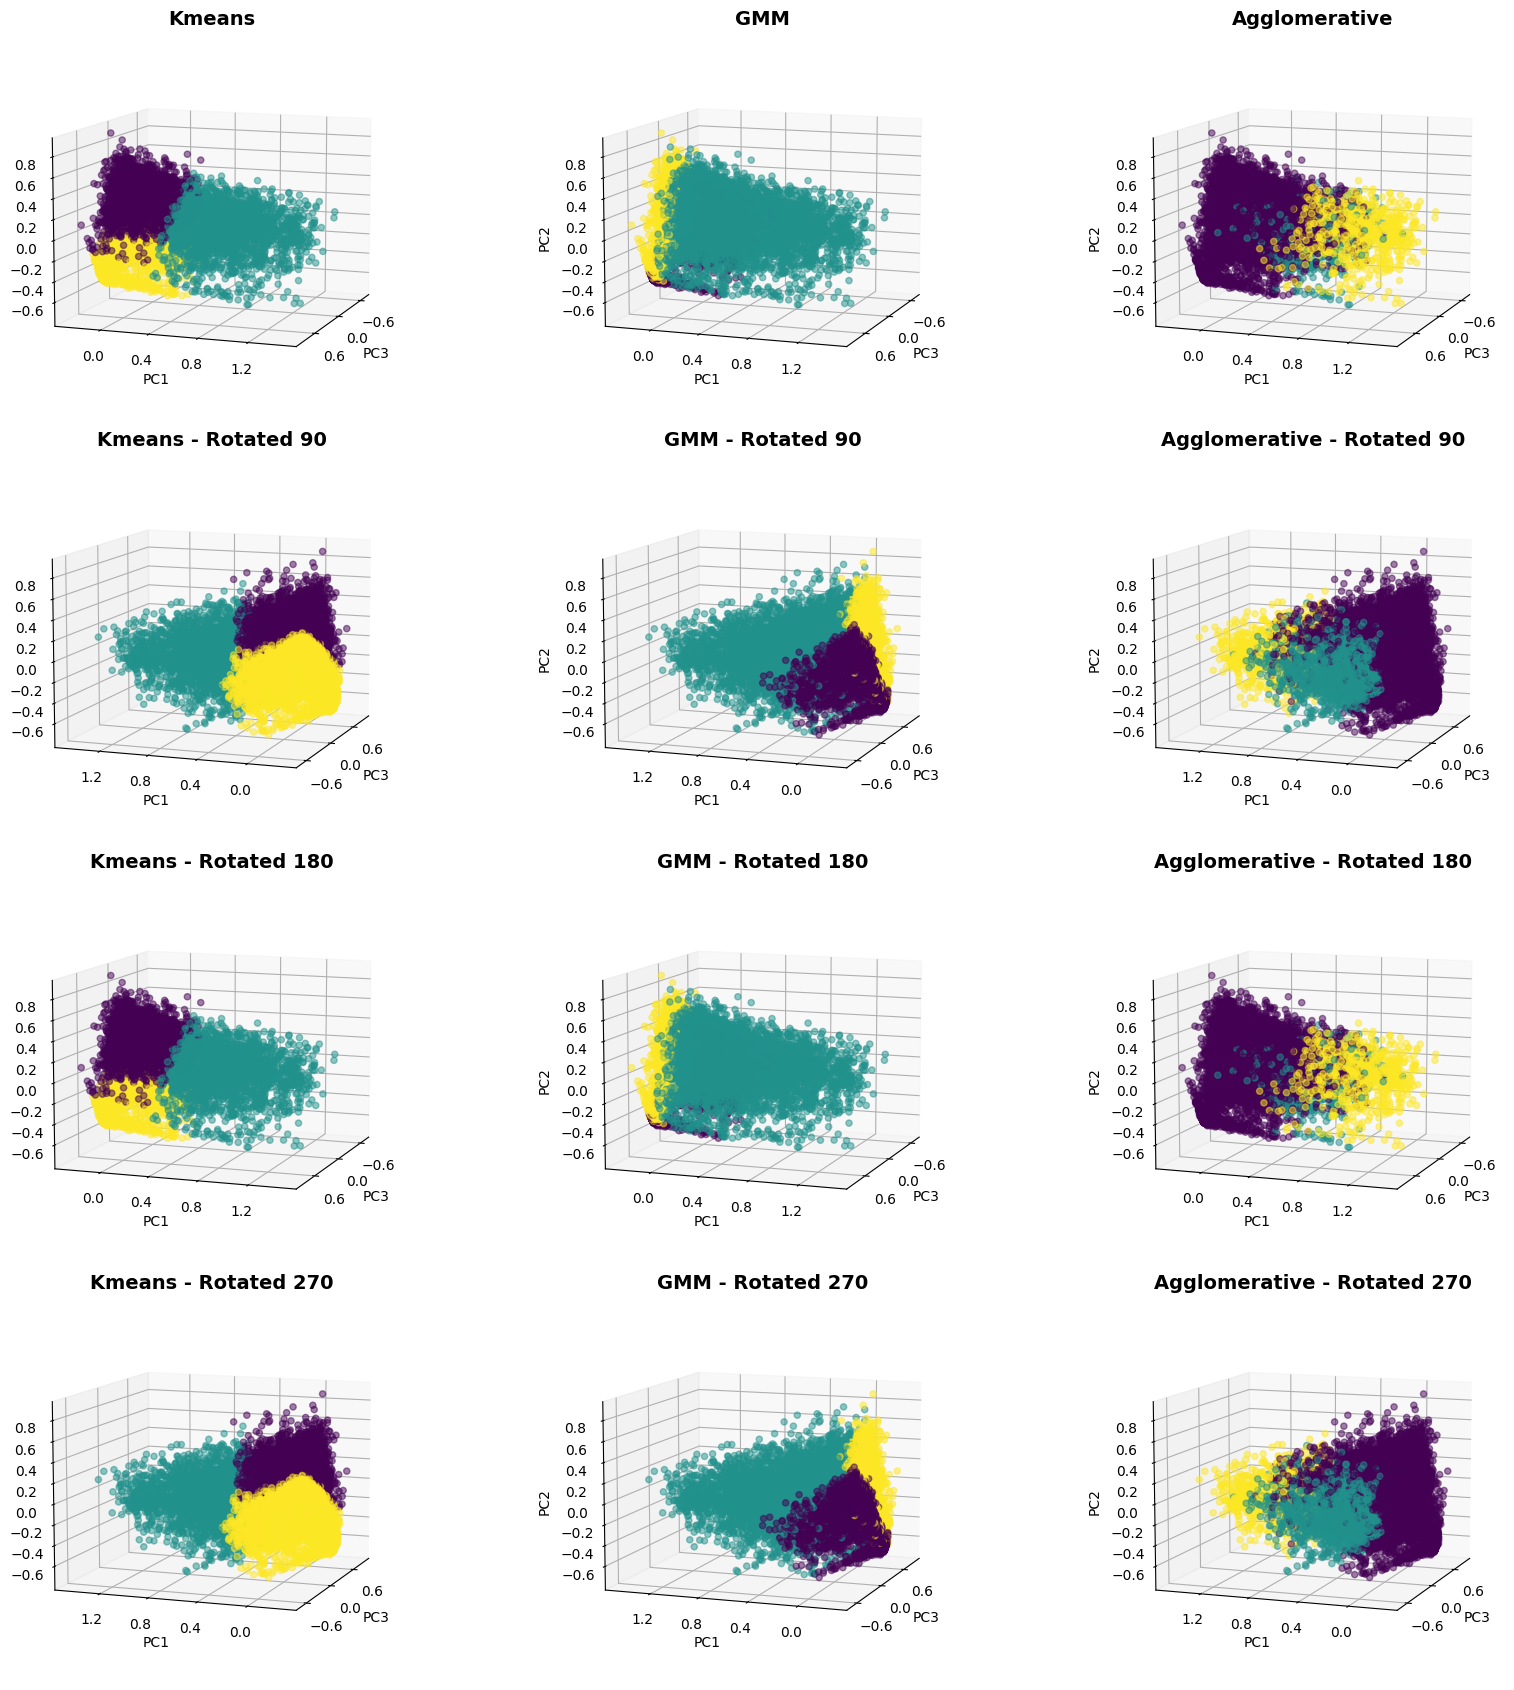

In [481]:
def plot_3d_scatter(pca_data, y_predicteds, titles, exclude=[]):
    """
    Plot 3D scatters for a given set of PCA data and fighter clusters (y-predicted).
    """
    
    x = pca_data[:, 0]
    y = pca_data[:, 1]
    z = pca_data[:, 2]
    
    fig, axes = plt.subplots(4, len(titles), figsize=[25, 17])
    # fig.subplots_adjust(left=0.8, right=0.9, bottom=0.3, top=0.9)

    
    subtitles = ['', ' - Rotated 90', ' - Rotated 180', ' - Rotated 270']
    cnt = 0
    for ii, y_predicted, title in zip(range(len(titles)), y_predicteds, titles):
        for i in range(0,4):
            cnt += 1
            ax = plt.subplot(4, 3, ii + 1 + 3 * i, projection='3d')
            ax.scatter(z, x, y, c=pd.Series(y_predicted), alpha=0.5)
            ax.set_xlabel('PC3', fontsize=10)
            ax.set_ylabel('PC1', fontsize=10)
            ax.set_zlabel('PC2', fontsize=10, rotation=90)
            ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
            ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
            ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
            ax.view_init(elev=10, azim=20 + i * 180)
            ax.set_title(title + subtitles[i], fontsize=14, fontweight='bold')
            ax.set_xticks(ax.get_xticks(), fontsize=8)
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    fig.tight_layout()
plot_3d_scatter(final_cluster_data_pca, [final_cluster_data_copy['kmeans'], 
                                        final_cluster_data_copy['gaussian'], 
                                        final_cluster_data_copy['agglomerative']], 
                                        ['Kmeans', 'GMM', 'Agglomerative'])

In [425]:
print(silhouette_score(final_cluster_data_pca, final_cluster_data_copy['kmeans']), 
    silhouette_score(final_cluster_data_pca, final_cluster_data_copy['gaussian']), 
    silhouette_score(final_cluster_data_pca, final_cluster_data_copy['agglomerative']))

0.2252867176470418 0.06250883378645958 0.2654007953847191


In [482]:
grapplers = ('Yoel', 'Khabib', 'Georges St-Pierre', 'Daniel Cormier', 'Islam Mak', 'Demetrious Johnson')
tactical_strikers = ('Anderson Silva', 'Israel Ades', 'Jose Aldo', 'Conor McG', 'Max Holloway')
hard_hitters = ('Francis Ng', 'Derrick Lewis', 'Justin Ga', 'Thiago Santos', 'Jan Blachowicz')
pd.concat([modes[modes['name'].str.startswith(grapplers)], 
          modes[modes['name'].str.startswith(tactical_strikers)], 
          modes[modes['name'].str.startswith(hard_hitters)]])

,name,kmeans,gaussian,agglomerative
502,Daniel Cormier,0,1,0
575,Demetrious Johnson,0,1,0
776,Georges St-Pierre,1,1,0
883,Islam Makhachev,1,1,0
1280,Khabib Nurmagomedov,1,1,2
2259,Yoel Romero,0,1,0
115,Anderson Silva,2,2,0
447,Conor McGregor,2,0,0
885,Israel Adesanya,0,2,0
1144,Jose Aldo,0,2,0


In [480]:
modes

,name,kmeans,gaussian,agglomerative
0,AJ Dobson,0,2,0
1,AJ Fletcher,0,1,0
2,Aalon Cruz,2,0,0
3,Aaron Brink,2,0,0
4,Aaron Phillips,2,2,0
...,...,...,...,...
2291,Zhang Lipeng,1,1,0
2292,Zhang Tiequan,2,2,0
2293,Zhang Weili,0,1,0
2294,Zubaira Tukhugov,0,1,0
